In [2]:
import numpy as np
import math
from skimage import io, color
import matplotlib.pyplot as plt

In [3]:
# functia care calculeaza imaginea integrala
def img_integrala(img, var):
    L,C = np.shape(img)
    img_out = np.zeros((L,C))
    if var == 1:
        img_out = np.cumsum(np.cumsum(img,axis=1), axis=0)
        return img_out
    elif var == 2:
        for i in range(0,L):
            for j in range(0,C):
                if i==0 and j==0:
                    img_out[i,j] = img[i,j]
                elif i==0 and j!=0:
                    img_out[i,j] = img[i,j] + img_out[i,j-1]
                elif i!=0 and j==0:
                    img_out[i,j] = img[i,j] + img_out[i-1,j]
                elif i!=0 and j!=0:
                    img_out[i,j] = img[i,j] + img_out[i,j-1] + img_out[i-1,j] - img_out[i-1,j-1]
        return img_out

In [4]:
#matrici de TEST
a=np.array([[1,2,3],[4,5,6],[7,8,9]])
b=np.array([[3,2,1,1],[1,2,3,4]])

a_out = img_integrala(a,1)
b_out = img_integrala(b,1)

print(a)
print(a_out)
print(b_out)

a_out_2 = img_integrala(a,2)
b_out_2 = img_integrala(b,2)

print(a_out_2)
print(b_out_2)


[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[ 1  3  6]
 [ 5 12 21]
 [12 27 45]]
[[ 3  5  6  7]
 [ 4  8 12 17]]
[[ 1.  3.  6.]
 [ 5. 12. 21.]
 [12. 27. 45.]]
[[ 3.  5.  6.  7.]
 [ 4.  8. 12. 17.]]


In [5]:
print (a_out==a_out_2,b_out==b_out_2)

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]] [[ True  True  True  True]
 [ True  True  True  True]]


In [6]:
###
# Z = A + D - B - C
# calcul suma dintr-o fereastra

#calcul dreptunghi din img_integ
def suma_dreptunghi(poz_i, poz_j, h_fer, w_fer, img_out):
    A=0
    B=0
    C=0
    D=0
    if poz_i==0 and poz_j==0:
        D = img_out[poz_i+h_fer-1, poz_j+w_fer-1]
    elif poz_i==0 and poz_j!=0:
        C = img_out[poz_i+h_fer-1, poz_j-1]
        D = img_out[poz_i+h_fer-1, poz_j+w_fer-1]
    elif poz_i!=0 and poz_j==0:
        B = img_out[poz_i-1,poz_j+w_fer-1]
        D = img_out[poz_i+h_fer-1, poz_j+w_fer-1]
    elif poz_i!=0 and poz_j!=0:
        A = img_out[poz_i-1,poz_j-1]
        B = img_out[poz_i-1,poz_j+w_fer-1]
        C = img_out[poz_i+h_fer-1, poz_j-1]
        D = img_out[poz_i+h_fer-1, poz_j+w_fer-1]
    
    sum = A+D-B-C
    return sum
    # PARAMETRII : perechea (l,c) pentru pixelul curent,dimensiunea imaginii,imaginea integrala
    # RETURN : Z=suma intensitatilor pixelilor din dreptunghiul ales
    
    # Calculez A,B,C,D conform celor discutate folosind imag integrala calculata anterior
    # Aveti grija si la cazurile limita (daca ma aflu in anumite extremitati din imagine
    # unele zone nu pot fi calculate)

In [7]:
#verificam daca va calcula corect suma pentru dreptunghiurile alese
# primele 2 linii din a
dr1=suma_dreptunghi(0,0,2,3,a_out)
# [[5,6],[8,9]]
dr2=suma_dreptunghi(1,1,2,2,a_out)
# [[2,1],[2,3]]
dr5=suma_dreptunghi(0,1,2,2,b_out)

# ar treb sa fie (21,28,8)
print(dr1,dr2,dr5)

21 28 8


In [24]:
# filtrul Lee
def filt_LEE(w_size, h_img, w_img, img_integrala, img_integrala_la_patrat, noise_var, img_denoise):
    
    #PARAMETRII : capat,dim ferestrei,dim imaginii,img_integ pt imaginea init
    #             img_integ pt img_init la patrat, copie a imaginii initiale
    #             pt a calcula noile valori filtrate

    capat = math.floor(w_size/2)

    #RETURN img filtrata(img_denoise)
    #parcurgem imaginea si "plimbam" feresetrele
    for i in range(capat,h_img-capat):
        for j in range(capat,w_img-capat):

            # ecuatia filtrului : I_out=alpha * I_med + (1-alpha) * I
            # unde I_out - noua valoare a pixelului filtrat
            #      alpha = sqrt (noise_var/fer_var) [0,1]
            #      I_med = media pixelilor din fereastra
            #      I = pixelul original din imaginea curenta
            #      fer_var=I**2_med - I_med**2

            # zona uniforma => alpha ~ 1 => I_new = I-med
            # zona cu detaliu => alpha ~ 0 => I_new ~ I
            # var_zg = 
            # var_fer = (I^2)_med - I_med^2
            # calculez I_med**2(media pixelilor din ferastra la patrat)
            # folosind functia suma_dreptungi(dreptunghiul e fiec fereastra)
            img_med=suma_dreptunghi(i-capat, j-capat, w_size, w_size, img_integrala) / (w_size**2)
            img_med_patrat=img_med**2
            
            # calculez I**2_med(media pixelilor ridicati la patrat din ferastra )
            img_patrat_med= suma_dreptunghi(i-capat, j-capat, w_size, w_size, img_integrala_la_patrat) / (w_size**2)
            
            #calculez varianta ferestrei fer_var
            fer_var= img_patrat_med - img_med_patrat
            
            #ma asigur ca varianta din fereastra nu e mai mare ca cea a zg
            #altfel ar exista unele sanse ca alpha sa fie > 1, dar el apartine [0,1]
            fer_var = max(fer_var,noise_var)
            
            #calculez alpha conform formulei cu radical
            alpha = np.sqrt(noise_var/fer_var) 
            
            #calculez noua valoare a pixelului filtrat
            img_denoise[i,j] = img_med*alpha + img_denoise[i,j]*(1-alpha)
  
    return img_denoise

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1865def4750>)

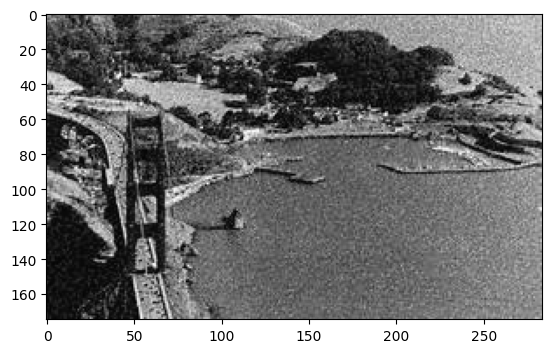

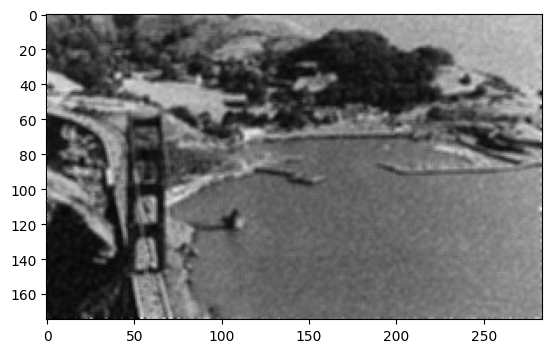

In [28]:
#citim imag initiala cu zg gauss, o transf in gray, aflu dim si o afisez
img_Lee=io.imread('noise_img1.jpg')
img_Lee_gray=color.rgb2gray(img_Lee)
plt.figure(),plt.imshow(img_Lee_gray,cmap='gray') 
h,w=np.shape(img_Lee_gray)

#aflu varianta zgomotului
# folosesc functia .var() din numpy pe o zona uniforma din img_Lee
noise_var=img_Lee[:10, :10].var()

# fac o copie a imaginii in care sa pun pixelii filtrati
img_denoise=img_Lee_gray.copy()

#calculez imaginea integrala pentru img initiala si img initiala la patrat
# folosind fctia scrisa anterior
img_integ3=img_integrala(img_Lee_gray,var=1)
img_integ4=img_integrala(img_Lee_gray**2,var=1)

# dim ferestrei de filtrare(3 pt 3*3,5 pt (5*5),etc)
size=3

# generalizarea numarului de linii si coloane care se pierd 
# in functie de dim ferestrei
capat = size//2

#returnez imaginea filtrata si o afisez
img_denoise=filt_LEE(size,h,w,img_integ3,img_integ4,noise_var,img_denoise)
plt.figure(),plt.imshow(img_denoise,cmap='gray')      